# Example of the `aitlas` toolbox in the context of image segmentation

This notebook shows a sample implementation of a image segmentation using the `aitlas` toolbox.

In [1]:
%matplotlib inline

Import the required packages

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import os

from aitlas.datasets import ChactunDataset
from aitlas.models import DeepLabV3
from aitlas.tasks.predict import ImageFolderDataset
from aitlas.visualizations import display_image_segmentation

2021-04-08 15:22:24,144 INFO Loading faiss with AVX2 support.
2021-04-08 15:22:24,145 INFO Loading faiss.


## Visualize images and masks

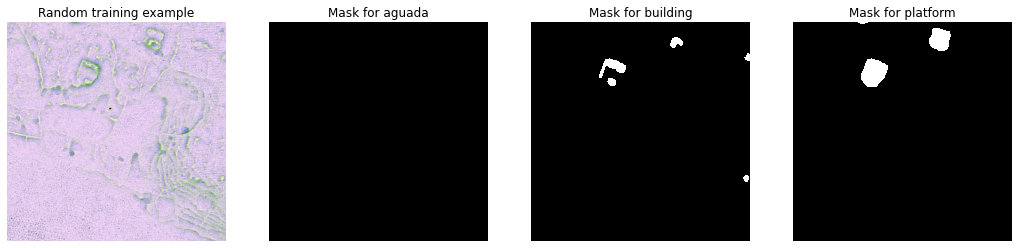

In [3]:
example_image = Image.open('/media/ssd/Chactun/train/tile_1185_lidar.tif')
example_mask1 = Image.open('/media/ssd/Chactun/train/tile_1185_mask_aguada.tif')
example_mask2 = Image.open('/media/ssd/Chactun/train/tile_1185_mask_building.tif')
example_mask3 = Image.open('/media/ssd/Chactun/train/tile_1185_mask_platform.tif')

plt.rcParams["figure.figsize"] = (18, 9) # (w, h)
plt.subplot(1,4,1)
plt.imshow(example_image)
plt.title(f"Random training example")
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(example_mask1, cmap='gray')
plt.title(f"Mask for aguada")
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(example_mask2, cmap='Greys',  interpolation='nearest')
plt.title(f"Mask for building")
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(example_mask3, cmap='Greys',  interpolation='nearest')
plt.title(f"Mask for platform")
plt.axis('off')
plt.show()

## Load data

In [4]:
train_dataset_config = {
    "batch_size": 4,
    "shuffle": True,
    "num_workers": 4,
    "root": "/media/ssd/Chactun/train",
    "transforms": ["aitlas.transforms.MinMaxNormTransponse"],
    "target_transforms": ["aitlas.transforms.MinMaxNorm"]
}
train_dataset = ChactunDataset(train_dataset_config)
len(train_dataset)

1344

## Training

In [6]:
epochs = 50
model_directory = "/media/ssd/Chactun/experiments/"
model_config = {"num_classes": 3, "learning_rate": 0.0001,"pretrained": True, "threshold": 0.5}

model = DeepLabV3(model_config)

model.train_model(
    train_dataset=train_dataset,
    epochs=epochs,
    model_directory=model_directory,
)

## Evaluation

In [ ]:
test_dataset_config = {
    "batch_size": 4,
    "shuffle": False,
    "num_workers": 4,
    "transforms": ["aitlas.transforms.MinMaxNormTransponse"],
    "target_transforms": ["aitlas.transforms.MinMaxNorm"]
}

test_dataset = ChactunDataset(test_dataset_config)
len(test_dataset)

model_path = "/media/ssd/chactun_new/experiments/checkpoint_1617407560.pth.tar"
model.evaluate(dataset=test_dataset, model_path=model_path)
model.running_metrics.get_f1scores()

## Predictions

2021-04-08 15:22:45,390 INFO Loading checkpoint /media/ssd/chactun_new/experiments/checkpoint_1617407560.pth.tar
2021-04-08 15:22:45,843 INFO Loaded checkpoint /media/ssd/chactun_new/experiments/checkpoint_1617407560.pth.tar at epoch 51
running prediction: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


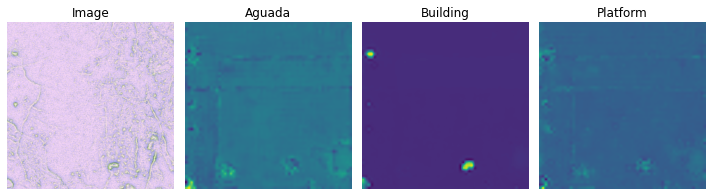

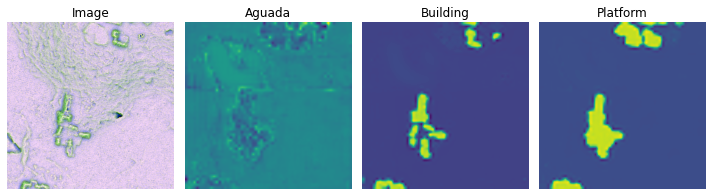

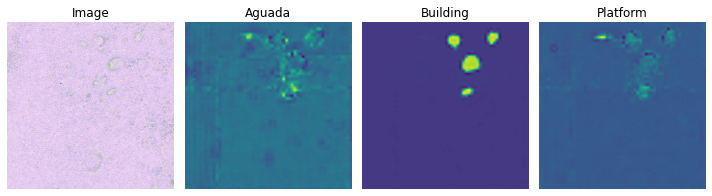

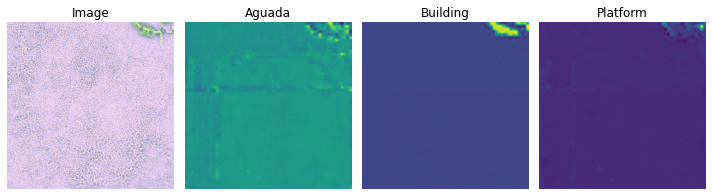

In [7]:
# run predictions
model_path = "/media/ssd/chactun_new/experiments/checkpoint_1617407560.pth.tar"
predict_dir = "/media/ssd/chactun_new/predict/"
results_dir = "/media/ssd/chactun_new/experiments/results"
labels = ["Aguada", "Building", "Platform"]
transforms = ["aitlas.transforms.MinMaxNormTransponse"]

predict_dataset = ImageFolderDataset(predict_dir, labels, transforms)
len(predict_dataset)

# load the model
model.load_model(model_path)

# Run predictions
y_true, y_pred, y_prob = model.predict(dataset=predict_dataset)

# plot predictions
for i, image_path in enumerate(predict_dataset.data):
    plot_path = os.path.join(results_dir, f"{predict_dataset.fnames[i]}_plot.png")
    display_image_segmentation(
        image_path,
        y_true[i],
        y_pred[i],
        y_prob[i],
        predict_dataset.labels,
        plot_path,
    )